In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from math import factorial 
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize

# Calculating shapley values
$\phi_i \rightarrow$ Shapley value for feature $i$ **(e.g.: {Age})**<br>
$f \rightarrow$ Black Box Model<br>
$x \rightarrow$ Input data point<br>
$z' \rightarrow$ Subset **(e.g.: {Age, BMI})**<br>
$x' \rightarrow$ Simplified data input<br>
Using a **mapping function** we transform $x \rightarrow x'$ <br>
$z'\subseteq x' \rightarrow$ Iterate over all possible combinations of features<br>
$f_x(z') \rightarrow$ Black Box Model output for our input **with** the feature(s) we are interested in **(e.g.:{Age, BMI})**<br>
$f_x(z' \backslash i) \rightarrow$ Black Box Model output for our input **without** the feature(s) we are interested in **(e.g.:{BMI})**<br>
$[f_x(z') - f_x(z' \backslash i)] \rightarrow$ Tells us how feature $i$ contributed to that subset. Also called the **marginal value**<br>
$M \rightarrow$ Total number of features<br>
$\frac{|z'|!(M - |z'| - 1)!}{M!} \rightarrow$ Weighting according to how many players are in that correlation<br><br>
$$\phi_i(f,x) = \sum_{z'\subseteq x'} \frac{|z'|!(M - |z'| - 1)!}{M!} [f_x(z') - f_x(z' \backslash i)]$$
<br>
- Intuition: The contribution of adding the feature $i$ should be weighted more if already many features are included in that subset
<br>

# Linear SHAP

In [2]:
# Defining the dataset
X = pd.DataFrame({'a': [2, 4, 8, 0, 3, 6, 9],
  'b': [1, 5, 0, 7, 1, -2, 5]})
y = 5*X['a'] + 2*X['b'] + 3

In [9]:
# Defining a linear model
linear_model = LinearRegression()
linear_model.fit(X, y)
print("Model coefficients:")
for i in range(X.shape[1]):
   print(X.columns[i], "=", linear_model.coef_[i].round(4))

Model coefficients:
a = 5.0
b = 2.0


In [11]:
# Calculate linear SHAP
# this are the shapley values for sample 0-1
shap_values = ((X[:1] - X.mean()) * linear_model.coef_)
shap_values_table = shap_values.T
shap_values_table.columns = ['SHAP_value']
shap_values_table

,SHAP_value
a,-12.857143
b,-2.857143


In [14]:
explainer = shap.LinearExplainer(linear_model, X)
shap_values = explainer.shap_values(X[:1])
shap_values

array([[-12.85714286,  -2.85714286]])

In [12]:
X.mean()

a    4.571429
b    2.428571
dtype: float64

In [46]:
newx, newy = make_regression(n_samples=5000, n_features=3)
newx = binarize(newx)
X_train, X_test, y_train, y_test = train_test_split(newx, newy, 
                            test_size=0.2, random_state=42)
lin = LinearRegression().fit(X_train, y_train)
explainer = shap.Explainer(lin.predict, X_test)
shap_values2 = explainer(newx)

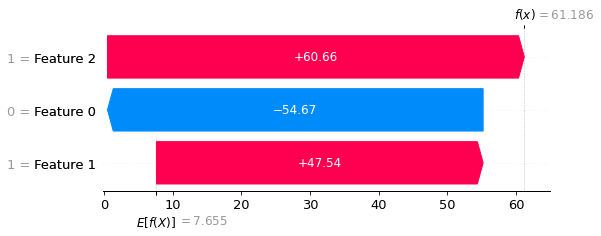

In [47]:
shap.plots.waterfall(shap_values2[sample_ind], max_display=14)

In [52]:
def get_subsets(x,featnum):
    lst = map(list, itertools.product([0, 1], repeat=len(x)))
    lst = list(lst)
    new_lst = []
    for j in lst:
        if j[featnum] == 1 and sum(j)!=len(x):
            k = j[:]
            k[featnum] = 0
            new_lst.append([j, k])
            print([j, k])
    
    return new_lst

def get_sample(subset, x):
    res = []
    for i in range(len(subset)):
        if subset[i] == 1:
            res.append(x[i])
        else:
            #ISSUE IS: HOW TO DOES SHAP HANDLE RANDOM
            res.append(newx[:,i][np.random.randint(0, len(newx))])
    return res
            
def getshap(model, x, feat):
    z = get_subsets(x, 0)
    total = 0
    for subset in z:
        mini_z = sum(subset[0])
        left = (factorial(mini_z) * factorial(len(x)-mini_z-1)/factorial(len(x)))
        right1 = model.predict([get_sample(subset[0], x)])
        right2 = model.predict([get_sample(subset[1], x)]) 
        right = right1 - right2
        total = total + (left*right)
    return total

getshap(lin, newx[sample_ind], 0)

[[1, 0, 0], [0, 0, 0]]
[[1, 0, 1], [0, 0, 1]]
[[1, 1, 0], [0, 1, 0]]


array([-97.77141982])

Reinforcement learning can be divided based on whether the machine uses a model to learn or **learns by itself**:
- Reinforcement Learnning
    - Model-based
        - Learn the model
        - Given model
    - Model-free
        - Policy Optimization
        - Q-Learning
        
---

New terms:
- **Episodes**: When an agent ends up in a terminating state and cant take a new action
- **Q-value**: Used to determine how good an Action $A$, taken a particular state $S$ is , that is $Q(A,S)$
- **Temporal Difference**: Formula used to find the Q-value by using the value of current state and action and previous state and action
<br>
- **Bellman Equation:** used to determine the value of a particular state, and deduce how good it is to take that state. The optimal state will give us the highest optimal value.


$Q(S,A) \rightarrow$ Current Q-value<br>
$R(S,A) \rightarrow$ Current Reward<br>
$(S,A) \rightarrow$ Current State and Action<br>
$(S',A') \rightarrow$ Previous State and Action<br>
$Max Q'(S',A') \rightarrow$ Maximum expected future reward<br>
$\lambda \rightarrow$ discount rate<br>
$\alpha \rightarrow$ learning reate<br>

$$NewQ(S,A) = Q(S,A) + \alpha [R(S,A) + \lambda Max Q'(S',A') - Q(S,A)]$$<br>